In [140]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
import pandas as pd
import numpy as np

import seaborn as sns
import seaborn.objects as so
# Apply the default theme
sns.set_theme()
sns.set_style("whitegrid")
import matplotlib.pyplot as plt

from IPython.display import display, Latex


import sys
sys.path.insert(0, "../scripts")
import ml_window as m 
import helpers as h

import json 
# import streamlit as st


### import data

In [113]:
# macro f1 score...
with open("../constants/svm_metrics_230704.json") as f:
    svm_data =json.load(f)

with open("../constants/ewm_metrics_230704.json") as f:
    ewm_data =json.load(f)

### transform times to hours in data sets

In [114]:
# need to go through all the data and turn false and true open time and turn into hours

def get_nice_time(td_string):
    return pd.to_timedelta(td_string)/ np.timedelta64(1, 'h')

for exp in svm_data.values():
    for model in exp.values():
        model["metrics"]["drdr"]["true open time"] = get_nice_time(model["metrics"]["drdr"]["true open time"])
        model["metrics"]["drdr"]["false open time"] = get_nice_time(model["metrics"]["drdr"]["false open time"])

for exp in ewm_data.values():
    for model in exp.values():
        model["drdr"]["true open time"] = get_nice_time(model["drdr"]["true open time"])
        model["drdr"]["false open time"] = get_nice_time(model["drdr"]["false open time"])


### assemble data from svm and ewm datasets and sort 

In [115]:
def safeget(dct, keys_arr):
    assert type(keys_arr) == list
    keys = keys_arr
    for key in keys:
        try:
            dct = dct[key]
        except KeyError:
            return False
    return dct

In [116]:
sort_key_dict = {
        "f1": ["standard", "macro avg", "f1-score"],
        "hits_guesses_ratio": ["custom", "(hits + near hits)/guesses",], #hits and near hits/guesses
        "guesses_actions_ratio": ["custom", "guesses/actions",], #guesses/actions,
        "opening_acc": ["drdr", "bounded acc"] ,#opening accuracy
        "unbounded_opening_acc": ["drdr", "unbounded acc"], 
        "true_time": ["drdr", "true open time"],
        "false_time": ["drdr", "false open time"] 
    } 

def sort_and_return_quick_result(all_results, data_type="svm", sort_key="f1", key_dict=sort_key_dict):   

    key_arr = key_dict[sort_key]

    # TODO consider this 
    # reverse_direction = False if sort_key == "false_time" or sort_key == "guesses_actions_ratio" else True

    reverse_direction = False if sort_key == "false_time" else True

    # svm 
    if data_type=="svm":
        sorted_results = sorted(all_results.items(), key=lambda x:safeget(x[1]["metrics"], key_arr), reverse=reverse_direction)
        quick_res = [
            {
            "name": v["name"],
            "val": safeget(v["metrics"], key_arr)
            }
            for k,v in sorted_results]
    # ewm 
    else:
        sorted_results = sorted(all_results.items(), key=lambda x:safeget(x[1], key_arr), reverse=reverse_direction)
        quick_res = [
        {
            "name": k,
            "val":  safeget(v, key_arr),
        }
        for k,v in sorted_results]
    return quick_res, sorted_results 

In [117]:
# quick, slow = sort_and_return_quick_result(svm_data["exp_A"], "svm", "f1")
# quick[0:3]

# quick, slow = sort_and_return_quick_result(ewm_data["exp_A"], "ewm")
# quick

In [118]:
dif_sort_dfs = {}

for sort_key in sort_key_dict.keys():
    exps = list(ewm_data.keys())

    data_pts = {}
    for exp in exps:
        data_pts[exp] = []
        for data_type, data in zip(["ewm", "svm"], [ewm_data, svm_data]):
            quick, slow = sort_and_return_quick_result(data[exp], data_type, sort_key)
            if data_type == "ewm":
                res = list(filter(lambda x: True if x["name"] == "z=1" else False, quick))
                data_pts[exp].append(res[0])
                data_pts[exp][0]["chart_name"] = "EWM"
            else:
                data_pts[exp].extend(quick)
                for i in range(3):
                    data_pts[exp][i+1]["chart_name"] = f"SVM_{i+1}"

    for k,v in data_pts.items():
        for small_dict in v:
            small_dict["exp"] = k

    data_list = sum(data_pts.values(), [])

    df = pd.DataFrame(data_list)

    dif_sort_dfs[sort_key] = df


In [119]:
dif_sort_dfs["f1"]

,name,val,chart_name,exp
0,z=1,0.724242,EWM,exp_A
1,"[dt_meas_temp, dt_meas_rh]",0.709422,SVM_1,exp_A
2,"[meas_temp, meas_rh, dt_meas_temp, dt_amb_rh]",0.698951,SVM_2,exp_A
3,"[meas_temp, meas_rh, dt_meas_temp, dt_amb_temp]",0.693715,SVM_3,exp_A
4,"[meas_temp, dt_meas_temp, dt_meas_rh, dt_amb_rh]",0.686005,NaN,exp_A
...,...,...,...,...
337,"[meas_temp, amb_temp]",0.459252,NaN,exp_C
338,"[amb_minus_meas_temp, meas_minus_deriv_rh]",0.444231,NaN,exp_C
339,[meas_temp],0.430241,NaN,exp_C
340,"[amb_minus_meas_rh, meas_minus_deriv_temp]",0.414189,NaN,exp_C


In [120]:
# dif_sort_dfs["guesses_actions_ratio"] = dif_sort_dfs["guesses_actions_ratio"].loc[dif_sort_dfs["guesses_actions_ratio"]["val"] <20]

# dif_sort_dfs["guesses_actions_ratio"]

### make nicer names for plotting 

In [121]:
latex_names = {
    "meas_temp": "$T_{meas}$",
    "meas_rh": "$RH_{meas}$",

    "amb_temp":"$T_{amb}$",
    "amb_rh": "$RH_{amb}$",

    "dt_meas_temp": "$\\frac{\mathrm{d}}{\mathrm{d}t}T_{meas}$",
    "dt_meas_rh": "$\\frac{\mathrm{d}}{\mathrm{d}t}RH_{meas}$",
    "dt_amb_temp": "$\\frac{\mathrm{d}}{\mathrm{d}t}T_{amb}$",
    "dt_amb_rh": "$\\frac{\mathrm{d}}{\mathrm{d}t}RH_{amb}$",

    "amb_minus_meas_temp": "$T_{amb} - T_{meas}$",
    "amb_minus_meas_rh": "$RH_{amb} - RH_{meas}$",
    "meas_minus_deriv_temp": "$T_{meas} - \\frac{\mathrm{d}}{\mathrm{d}t}T_{meas}$",
    "meas_minus_deriv_rh": "$RH_{meas} - \\frac{\mathrm{d}}{\mathrm{d}t}RH_{meas}$",
}

experiment_names = {
    "exp_A": "Exp A",
    "exp_B": "Exp B",
    "exp_C": "Exp C",
}

In [122]:
def change_name(x):
    if type(x) is list:
        # print(x)
        for ix, item in enumerate(x):
            try:
                x[ix] = latex_names[item] 
            except KeyError:
                # print(f"passed on {x}")  
                pass 
        return x 
    else: 
        # smoothing technique
        return "$\\text{ST}$" 

def join_names(x):
    if type(x) is not list:
        # smoothing technique 
        return x
    if len(x) < 2:
            temp = x[0]
    else:
        temp = "/".join(x)
        temp = temp.replace("$/$", ", ")
    temp = temp.replace("$", "$\\text{SVM: }", 1)
    
    return temp

In [123]:
# change tick names and legend names for plotting 
for k, v in dif_sort_dfs.items():
    print(f"\n {k}")
    v["name"] = v["name"].apply(change_name)
    v["name"] = v["name"].apply(join_names)
    v["exp"] = v["exp"].apply(lambda x: experiment_names[x])


 f1

 hits_guesses_ratio

 guesses_actions_ratio

 opening_acc

 unbounded_opening_acc

 true_time

 false_time


In [129]:
df_svm = dif_sort_dfs["f1"].loc[dif_sort_dfs["f1"].name.str.contains("ST") == False]
df_svm

,name,val,chart_name,exp
1,$\text{SVM: }\frac{\mathrm{d}}{\mathrm{d}t}T_{...,0.709422,SVM_1,Exp A
2,"$\text{SVM: }T_{meas}, RH_{meas}, \frac{\mathr...",0.698951,SVM_2,Exp A
3,"$\text{SVM: }T_{meas}, RH_{meas}, \frac{\mathr...",0.693715,SVM_3,Exp A
4,"$\text{SVM: }T_{meas}, \frac{\mathrm{d}}{\math...",0.686005,NaN,Exp A
5,"$\text{SVM: }T_{meas}, \frac{\mathrm{d}}{\math...",0.686005,NaN,Exp A
...,...,...,...,...
337,"$\text{SVM: }T_{meas}, T_{amb}$",0.459252,NaN,Exp C
338,"$\text{SVM: }T_{amb} - T_{meas}, RH_{meas} - \...",0.444231,NaN,Exp C
339,$\text{SVM: }T_{meas}$,0.430241,NaN,Exp C
340,"$\text{SVM: }RH_{amb} - RH_{meas}, T_{meas} - ...",0.414189,NaN,Exp C


In [130]:
df_st = dif_sort_dfs["f1"].loc[dif_sort_dfs["f1"].name.str.contains("ST")]
df_st

,name,val,chart_name,exp
0,$\text{ST}$,0.724242,EWM,Exp A
114,$\text{ST}$,0.461721,EWM,Exp B
228,$\text{ST}$,0.437793,EWM,Exp C


Text(0.5, 0, '')

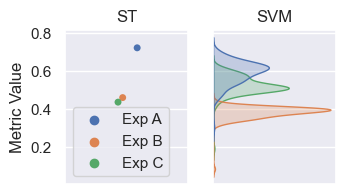

In [138]:
fig, axs = plt.subplots(1, 2,figsize=(3.5, 2), sharey=True, )
sns.stripplot(data=df_st, y="val",  hue="exp", legend=True, ax=axs[0])
sns.kdeplot(data=df_svm,  y="val", hue="exp",  fill=True, ax=axs[1], legend=False)

axs[0].set_title("ST")
axs[1].set_title("SVM")

axs[0].set_ylabel("Metric Value")
axs[0].legend(title="")

axs[1].set_xticks([])
axs[1].set_xlabel("")


In [127]:
proper_chart_titles_list = ["Macro Average F1 Score",
                    "Hits/Guesses",
                    "Guesses/Actions",
                    "Opening Accuracy",
                    "Unbounded Opening Accuracy",
                    "True Opening Time (Hours)",
                    "False Opening Time (Hours)"]
proper_chart_titles = {k:v for k,v in zip(sort_key_dict.keys(), proper_chart_titles_list)}
proper_chart_titles

{'f1': 'Macro Average F1 Score',
 'hits_guesses_ratio': 'Hits/Guesses',
 'guesses_actions_ratio': 'Guesses/Actions',
 'opening_acc': 'Opening Accuracy',
 'unbounded_opening_acc': 'Unbounded Opening Accuracy',
 'true_time': 'True Opening Time (Hours)',
 'false_time': 'False Opening Time (Hours)'}

hi
hi


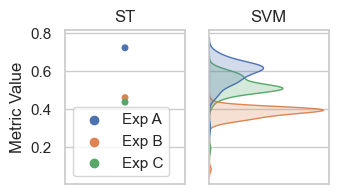

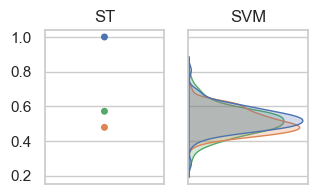

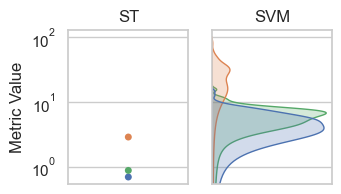

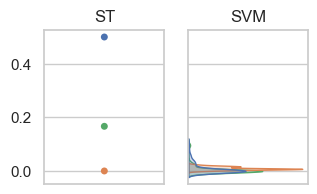

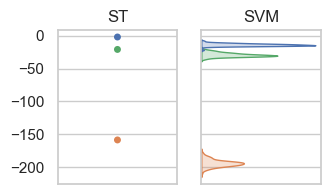

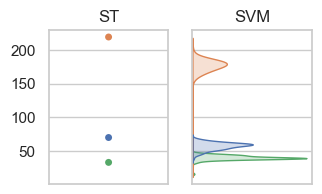

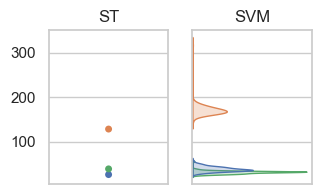

In [141]:
for ix, (k, v) in enumerate(dif_sort_dfs.items()):

    df_st = v.loc[v.name.str.contains("ST")]
    df_svm = v.loc[v.name.str.contains("ST") == False]


    fig, axs = plt.subplots(1, 2,figsize=(3.4, 2), sharey=True)
    sns.stripplot(data=df_st, y="val",  hue="exp", legend=True, ax=axs[0], jitter=False)
    sns.kdeplot(data=df_svm,  y="val", hue="exp",  fill=True, ax=axs[1], legend=False)

    axs[0].set_title("ST")
    axs[1].set_title("SVM")

    axs[0].set_ylabel("")
    axs[0].legend(title="")

    axs[1].set_xticks([])
    axs[1].set_xlabel("")

    if k == "guesses_actions_ratio" or k == "f1":
        print("hi")
        axs[0].set_ylabel("Metric Value")

    if k == "guesses_actions_ratio":
        plt.yscale("log")

    if ix != 0:
        axs[0].get_legend().remove()
        

    plt.savefig(f"../../summary/230613_buildsys/figs/res_dist_{k}.png", bbox_inches="tight")
